# 워드투벡터(Word2Vec)

- 단어 벡터 간 유의미한 유사도를 반영할 수 있도록 단어의 의미를 수치화 할 수 있는 방법

1. 희소 표현(Sparse Representation)
- 대안: 분산 표현(distributed representation)

2. 분산 표현(Distributed Representation)
-  '비슷한 문맥에서 등장하는 단어들은 비슷한 의미를 가진다

3. CBOW(Continuous Bag of Words)
- Word2Vec의 학습 방식에는 CBOW(Continuous Bag of Words)와 Skip-Gram 두 가지 방식
- CBOW: 주변에 있는 단어들을 입력으로 중간에 있는 단어들을 예측하는 방법
    - 윈도우(window): 중심 단어를 예측하기 위해서 앞, 뒤로 몇 개의 단어를 볼지를 결정해야 하는 범위 
- Skip-Gram: 중간에 있는 단어들을 입력으로 주변 단어들을 예측하는 방법

## 1-1. 영어/한국어 Word2Vec 실습

### 1.1.1 영어 Word2Vec 만들기

- gensim 패키지에는 Word2Vec을 지원
- 영어로 된 코퍼스를 다운받아 전처리를 수행하고, 전처리한 데이터를 바탕으로 Word2Vec 작업

In [1]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

1.1.1.1 훈련 데이터 이해하기

In [2]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x1c23ba75b80>)

In [ ]:
# 훈련 데이터 파일은 xml 문법으로 작성되어 있어 자연어를 얻기 위해서는 전처리가 필요
# 실질적 데이터는 영어문장으로만 구성된 내용을 담고 있는 <content>와 </content> 사이의 내용
# 전처리 작업을 통해 xml 문법들은 제거하고, 해당 데이터만 가져오기
# <content>와 </content> 사이의 내용 중에는 (Laughter)나 (Applause)와 같은 배경음을 나타내는 단어 제거

#### 1.1.1.2 훈련 데이터 전처리하기

In [3]:
targetXML = open('./data/ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [4]:
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273380


In [5]:
# 샘플 3개만 출력
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


#### 1.1.1.3 Word2Vec 훈련시키기

In [8]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

Word2Vec의 하이퍼파라미터

size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.

window = 컨텍스트 윈도우 크기

min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)

workers = 학습을 위한 프로세스 수

sg = 0은 CBOW, 1은 Skip-gram.

In [9]:
# Word2Vec는 입력한 단어에 대해서 가장 유사한 단어들을 출력하는 model.wv.most_similar을 지원
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.8473332524299622), ('guy', 0.8179163336753845), ('lady', 0.7808512449264526), ('boy', 0.7582191228866577), ('soldier', 0.7409019470214844), ('girl', 0.7349250316619873), ('gentleman', 0.7311205267906189), ('kid', 0.7178890705108643), ('poet', 0.6997151374816895), ('rabbi', 0.663277804851532)]


#### 1.1.1.4 Word2Vec 모델 저장하고 로드하기

In [10]:
model.wv.save_word2vec_format('./data/eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("./data/eng_w2v") # 모델 로드

In [11]:
# 로드한 모델에 대해서 다시 man과 유사한 단어를 출력
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.8473332524299622), ('guy', 0.8179163336753845), ('lady', 0.7808512449264526), ('boy', 0.7582191228866577), ('soldier', 0.7409019470214844), ('girl', 0.7349250316619873), ('gentleman', 0.7311205267906189), ('kid', 0.7178890705108643), ('poet', 0.6997151374816895), ('rabbi', 0.663277804851532)]


## 2.1 한국어 Word2Vec 만들기(네이버 영화 리뷰)

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from tqdm import tqdm

In [13]:
# 네이버 영화리뷰 데이터 
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x1c27cd48be0>)

In [15]:
# 네이버 영화 리뷰 데이터를 데이터프레임으로 로드하고 상위 5개
train_data = pd.read_table('./data/ratings.txt')

In [16]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [17]:
# 총 리뷰 개수를 확인
print(len(train_data)) # 리뷰 개수 출력

200000


In [18]:
# 결측값 유무를 확인
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


In [19]:
# 결측값이 존재하므로 결측값이 존재하는 행을 제거
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [20]:
# 결측값이 삭제된 후의 리뷰 개수를 확인
print(len(train_data)) # 리뷰 개수 출력

199992


In [21]:
# 정규 표현식을 통해 한글이 아닌 경우 제거하는 전처리를 진행
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

C:\Users\gnjnm\AppData\Local\Temp\ipykernel_27952\3335061672.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [22]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [26]:
# 불용어를 제거
# 형태소 분석기 Okt를 사용하여 각 문장에 대해서 일종의 단어 내지는 형태소 단위로 나누는 토큰화를 수행
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 199992/199992 [1:29:46<00:00, 37.13it/s]    


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


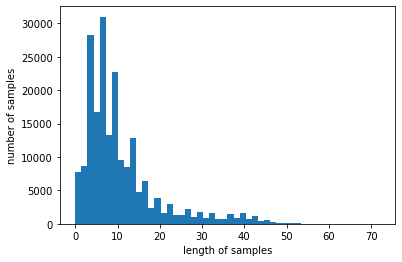

In [27]:
# 토큰화가 된 상태에서는 각 리뷰의 길이 분포 또한 확인이 가능
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [29]:
# Word2Vec으로 토큰화 된 네이버 영화 리뷰 데이터를 학습
from gensim.models import Word2Vec

# model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)  # size 만 쓰면 Error
model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [30]:
# 학습이 다 되었다면 Word2Vec 임베딩 행렬의 크기를 확인
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

In [31]:
# 총 16,477개의 단어가 존재하며 각 단어는 100차원
# '최민식'과 유사한 단어
print(model.wv.most_similar("최민식"))

# '히어로'와 유사한 단어
print(model.wv.most_similar("히어로"))

[('최민수', 0.8640745282173157), ('안성기', 0.861038863658905), ('한석규', 0.8563510179519653), ('이민호', 0.8356214761734009), ('엄태웅', 0.8310987949371338), ('김수현', 0.8224194645881653), ('송강호', 0.8214665055274963), ('설경구', 0.8208147883415222), ('서영희', 0.8191223740577698), ('유다인', 0.8173700571060181)]
[('슬래셔', 0.8928637504577637), ('호러', 0.8886445760726929), ('느와르', 0.8727526068687439), ('무협', 0.8708317279815674), ('블록버스터', 0.8705595135688782), ('멜로', 0.8312639594078064), ('무비', 0.8190279603004456), ('정통', 0.8154367208480835), ('헐리우드', 0.811850368976593), ('물', 0.8048973679542542)]


## 3-1.  사전 훈련된 Word2Vec 임베딩(Pre-trained Word2Vec embedding) 소개

- 감성 분류 작업을 하는데 훈련 데이터의 양이 부족한 상황
- 다른 방대한 데이터를 Word2Vec이나 GloVe 등으로 사전에 학습시켜놓은 임베딩 벡터들을 가지고 와서 모델의 입력으로 사용하는 것
- 사전 훈련된 워드 임베딩을 가져와서 간단히 단어들의 유사도를 구해보는 실습

- 구글이 제공하는 사전 훈련된(미리 학습되어져 있는) Word2Vec 모델을 사용하는 방법
- 구글은 사전 훈련된 3백만 개의 Word2Vec 단어 벡터들을 제공
- 임베딩 벡터의 차원은 300
- gensim을 통해서 이 모델을 불러오는 건 매우 간단합니다. 이 모델을 다운로드하고 파일 경로를 기재

- 모델 다운로드 경로 : https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

In [32]:
import gensim
import urllib.request

# 구글의 사전 훈련된 Word2Vec 모델을 로드.
urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
                           filename="GoogleNews-vectors-negative300.bin.gz")
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)


# 모델의 크기(shape)를 확인
print(word2vec_model.vectors.shape)

# 모델의 크기는 3,000,000 x 300입니다. 즉, 3백만 개의 단어와 각 단어의 차원은 300
# 사전 훈련된 임베딩을 사용하여 두 단어의 유사도를 계산
print(word2vec_model.similarity('this', 'is'))
print(word2vec_model.similarity('post', 'book'))

# 단어 'book'의 벡터를 출력
print(word2vec_model['book'])

HTTPError: HTTP Error 404: Not Found

## 4-1. 네거티브 샘플링을 이용한 Word2Vec 구현
(Skip-Gram with Negative Sampling, SGNS)

### 4.1.1 20뉴스그룹 데이터 전처리하기

In [33]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

# 하나의 샘플에 최소 단어 2개 > 중심 단어, 주변 단어의 관계가 성립
# 전처리 과정에서 지속적으로 이를 만족하지 않는 샘플들을 제거

In [34]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [35]:
# 전처리를 진행. 불필요한 토큰을 제거하고, 소문자화를 통해 정규화
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

C:\Users\gnjnm\AppData\Local\Temp\ipykernel_27952\669936866.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")


In [36]:
# 현재 데이터프레임에 Null 값이 있는지 확인
news_df.isnull().values.any()

False

In [37]:
# Null 값이 없지만, 빈 값(empy) 유무도 확인
# 모든 빈 값을 Null 값으로 변환하고, 다시 Null 값이 있는지 확인
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [38]:
# Null 값이 있음을 확인했습니다. Null 값을 제거
news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 10995


In [39]:
# NLTK에서 정의한 불용어 리스트를 사용하여 불용어를 제거
# 불용어를 제거
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [40]:
# 모든 샘플 중 단어가 1개 이하인 경우를 모두 찾아 제거
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


c:\Users\gnjnm\anaconda3\lib\site-packages\numpy\lib\function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [41]:
#  단어 집합을 생성하고, 정수 인코딩을 진행
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [42]:
# 상위 2개의 샘플을 출력
print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [43]:
# 단어 집합의 크기를 확인
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


### 4.1.2 네거티브 샘플링을 통한 데이터셋 구성하기

- 네거티브 샘플링을 통한 데이터셋을 구성할 차례
- 네거티브 샘플링을 위해서 케라스에서 제공하는 전처리 도구인 skipgrams를 사용
- 어떤 전처리가 수행되는지 그 결과를 확인하기 위해서 (꽤 시간이 소요되는 작업이므로) 상위 10개의 뉴스그룹 샘플에 대해서만 수행

In [44]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [45]:
# 결과를 확인합니다. 10개의 뉴스그룹 샘플에 대해서 모두 수행되었지만, 첫번째 뉴스그룹 샘플에 대해서만 확인
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(rediculous (15227), dispersed (20444)) -> 0
(degree (1530), austria (4866)) -> 1
(ignore (1979), fnajr (22956)) -> 0
(blessing (10669), commited (7837)) -> 1
(israels (13686), refinements (62423)) -> 0


In [46]:
# 윈도우 크기 내에서 중심 단어, 주변 단어의 관계를 가지는 경우에는 1의 레이블
# 그렇지 않은 경우는 0의 레이블
# 각각의 뉴스그룹 샘플에 대해서 동일한 프로세스로 수행
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 10


In [47]:
# 첫번째 뉴스그룹 샘플이 가지고 있는 pairs와 labels의 개수를 출력
print(len(pairs))
print(len(labels))

2220
2220


In [48]:
# 이 작업을 모든 뉴스그룹 샘플에 대해서 수행
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

### 4.1.3 Skip-Gram with Negative Sampling(SGNS) 구현하기

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [ ]:
# 하이퍼파라미터인 임베딩 벡터의 차원은 100으로 정하고, 두 개의 임베딩 층을 추가
embedding_dim = 100

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embedding_dim)(c_inputs)

In [ ]:
# 각 임베딩 테이블은 중심 단어와 주변 단어 각각을 위한 임베딩 테이블
# 각 단어는 임베딩 테이블을 거쳐서 내적을 수행
# 내적의 결과는 1 또는 0을 예측하기 위해서 시그모이드 함수를 활성화 함수로 거쳐 최종 예측값
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

### 4.1.4 결과 확인하기

- 학습된 모델의 결과를 확인
- 학습된 임베딩 벡터들을 vector.txt에 저장
- gensim의 models.KeyedVectors.load_word2vec_format()으로 로드하면 쉽게 단어 벡터 간 유사도

In [ ]:
import gensim

f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 모델 로드
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [ ]:
w2v.most_similar(positive=['soldiers'])

In [ ]:
w2v.most_similar(positive=['doctor'])

In [ ]:
w2v.most_similar(positive=['police'])

In [ ]:
w2v.most_similar(positive=['knife'])

In [ ]:
w2v.most_similar(positive=['engine']) 


### 5.1 글로브(GloVe)

- 글로브(Global Vectors for Word Representation, GloVe)는 카운트 기반과 예측 기반을 모두 사용하는 방법론
- 기존의 카운트 기반의 LSA(Latent Semantic Analysis)와 예측 기반의 Word2Vec의 단점을 지적하며 이를 보완한다는 목적

#### 5.1.1 윈도우 기반 동시 등장 행렬(Window based Co-occurrence Matrix)

- 단어의 동시 등장 행렬: 행과 열을 전체 단어 집합의 단어들로 구성하고, 
    - i 단어의 윈도우 크기(Window Size) 내에서 k 단어가 등장한 횟수를 i행 k열에 기재한 행렬

#### 5.1.2 동시 등장 확률(Co-occurrence Probability)

- 동시 등장 행렬로부터 특정 단어 i의 전체 등장 횟수를 카운트하고, 특정 단어 i가 등장했을 때 어떤 단어 k가 등장한 횟수를 카운트하여 계산한 조건부 확률

#### 5.1.3 GloVe 훈련시키기

- pip install glove_python_binary

In [ ]:
from glove import Corpus, Glove

corpus = Corpus() 

# 훈련 데이터로부터 GloVe에서 사용할 동시 등장 행렬 생성
corpus.fit(result, window=5)
glove = Glove(no_components=100, learning_rate=0.05)

# 학습에 이용할 쓰레드의 개수는 4로 설정, 에포크는 20.
glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)

In [7]:
import sys
sys.executable

'c:\\Users\\gnjnm\\anaconda3\\python.exe'

## 6-1. 패스트텍스트(FastText)

- FastText는 하나의 단어 안에도 여러 단어들이 존재하는 것으로 간주
- 내부 단어. 즉, 서브워드(subword)를 고려하여 학습

### 6.1.1 내부 단어(subword)의 학습

- FastText에서는 각 단어는 글자 단위 n-gram의 구성으로 취급
- n을 몇으로 결정하는지에 따라서 단어들이 얼마나 분리되는지 결정
- 시작과 끝을 의미하는 <, >를 도입하여 아래의 5개 내부 단어(subword) 토큰을 벡터로 만듦

### 6.1.2 모르는 단어(Out Of Vocabulary, OOV)에 대한 대응



### 6.1.3 단어 집합 내 빈도 수가 적었던 단어(Rare Word)에 대한 대응

### 6.1.4 실습으로 비교하는 Word2Vec Vs. FastText

- Word2Vec와 FastText의 차이를 비교

#### 6.1.4.1 Word2Vec

In [ ]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

In [ ]:
# Word2Vec의 실습( https://wikidocs.net/50739 )의 전처리 코드와 Word2Vec 학습 코드를 그대로 수행 완료 후
# 입력 단어에 대해서 유사한 단어를 찾아내는 코드에 이번에는 electrofishing이라는 단어
model.wv.most_similar("electrofishing")

#### 6.1.4.2 FastText

In [ ]:
# Word2Vec 학습 코드만 FastText 학습 코드로 변경하여 실행
from gensim.models import FastText

model = FastText(result, size=100, window=5, min_count=5, workers=4, sg=1)

In [ ]:
# electrofishing에 대해서 유사 단어를 찾기
model.wv.most_similar("electrofishing")

### 6.1.5 한국어에서의 FastText

#### 6.1.5.1 음절 단위

#### 6.1.5.2 자모 단위